In [1]:
import numpy as np
import cv2
import itertools
from itertools import cycle, combinations
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from keras.layers import Input, Conv2D, Dense, BatchNormalization, Reshape, MaxPooling2D, Dropout, Flatten, Lambda
from keras.models import Sequential, Model
from keras.datasets import mnist
import keras.backend as K

Using TensorFlow backend.


In [10]:
num_classes = 10
epochs = 12
image_height, image_width = 28, 28

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], image_height, image_width, 1)
x_test = x_test.reshape(x_test.shape[0], image_height, image_width, 1)
input_shape = (image_height, image_width, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Define model

In [9]:
from keras.layers import Concatenate

EMBEDDING_SIZE = 24

def triplet_loss(unused, stacked_dists):
    margin = K.constant(1)
    pos_dist = stacked_dists[:,0,0]
    neg_dist = stacked_dists[:,1,0]
    tert_dist = stacked_dists[:,2,0]
    return K.mean(K.maximum(K.constant(0), 
                            pos_dist - 0.5*(neg_dist + tert_dist) + margin))

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def accuracy(y_true, y_pred):
    return K.mean(y_pred[:,0,0] < y_pred[:,1,0])

input_shape=(image_height, image_width, 1)

input_anchor = Input(shape=input_shape, name='input_anchor')
input_positive = Input(shape=input_shape, name='input_pos')
input_negative = Input(shape=input_shape, name='input_neg')

base_model = Sequential()
base_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
base_model.add(Conv2D(64, (3, 3), activation='relu'))
base_model.add(MaxPooling2D(pool_size=(2, 2)))
base_model.add(Dropout(0.25))
base_model.add(Flatten())
base_model.add(Dense(128, activation='relu'))
base_model.add(Dropout(0.5))
base_model.add(Dense(num_classes, activation='sigmoid'))

net_anchor = base_model(input_anchor)
net_positive = base_model(input_positive)
net_negative = base_model(input_negative)

positive_dist = Lambda(euclidean_distance, name='pos_emb')([net_anchor, net_positive])
negative_dist = Lambda(euclidean_distance, name='neg_emb')([net_anchor, net_negative])
tertiary_dist = Lambda(euclidean_distance, name='ter_emb')([net_positive, net_negative])

stacked_dists = Lambda(lambda vects: K.stack(vects, axis=1), 
                       output_shape=(None, EMBEDDING_SIZE),
                       name='stacked_embs')([positive_dist, negative_dist, tertiary_dist])

model = Model([input_anchor, input_positive, input_negative], stacked_dists, name='triple_siamese')

model.compile(optimizer='adam',
              loss=triplet_loss,
              metrics=[accuracy])

In [4]:
stacked_dists.shape

TensorShape([Dimension(None), Dimension(3), Dimension(1)])

In [11]:
base_model.predict(x_train[0].reshape((1, image_height, image_width, 1)))

array([[0.49555492, 0.51869786, 0.4892794 , 0.511538  , 0.5051619 ,
        0.5319921 , 0.47961015, 0.48390597, 0.4930492 , 0.51413816]],
      dtype=float32)

In [12]:
digit_images = { digit: [] for digit in range(0, 10) }

for i in range(0, x_train.shape[0]):
    digit = y_train[i]
    digit_images[digit].append(x_train[i])

In [7]:
digit_images[3][0].shape

(28, 28, 1)

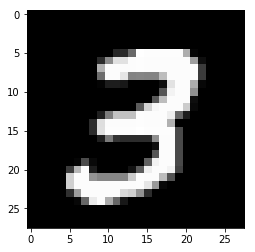

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(digit_images[3][0].reshape((28, 28)), cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

# Build batches

In [9]:
x_train.shape

(60000, 28, 28, 1)

In [13]:
batches = []

for i in range(0, 500):
    X_batch = []
    y_batch = []

    for digit in range(0, 10):
        random.shuffle(digit_images[digit])
        # Take 5 random images for each digit
        for i in range(0, 5):
            X_batch.append(digit_images[digit][i].reshape((image_height, image_width, 1)))
            y_batch.append(digit)

    batches.append({ 'X': np.array(X_batch), 'y': y_batch })

# Train model

In [10]:
base_model.predict(batches[0]['X']).shape

(50, 10)

In [11]:
batches[0]['y'][0]

0

In [14]:
def get_semihards(batch, embeddings, anchor, pos, digit):
    semihards = []
    for i in range(len(batch['y'])):
        if batch['y'][i] != digit and np.linalg.norm(anchor - pos) > np.linalg.norm(anchor - batch['X'][i]):
            semihards.append(batch['X'][i])
    return np.array(semihards)

def get_positives(batch, digit):
    pos = []
    for i in range(len(batch['y'])):
        if batch['y'][i] == digit:
            pos.append(batch['X'][i])
    return np.array(pos)

def get_triplets(batch, embeddings):
    triplets = [[], [], []]
    for digit in range(0, 10):
        pos = get_positives(batch, digit)
        pos_tuples = list(combinations(pos, 2))
        for anchor, pos in pos_tuples:
            semihards = get_semihards(batch, embeddings, anchor, pos, digit)
            for semihard in semihards:
                triplets[0].append(anchor)
                triplets[1].append(pos)
                triplets[2].append(semihard)
    return [np.array(triplets[0]), np.array(triplets[1]), np.array(triplets[2])]

In [15]:
MAX_TRIPLET_LIST_SIZE = 300

for i, batch in enumerate(batches[:50]):
    print('Training batch %s out of %s' % (i, len(batches)))
    embeddings = base_model.predict(batch['X'])
    triplets = get_triplets(batch, embeddings)
    
    for i in range(0, len(triplets[0]), MAX_TRIPLET_LIST_SIZE):
        triplet_sublist = [triplets[0][i:i+MAX_TRIPLET_LIST_SIZE], triplets[1][i:i+MAX_TRIPLET_LIST_SIZE], triplets[2][i:i+MAX_TRIPLET_LIST_SIZE]]
        _, acc = model.train_on_batch(triplet_sublist, np.zeros(len(triplet_sublist[0])))
        print('Accuracy on triplet sublist: %s' % acc)

Training batch 0 out of 500
Accuracy on triplet sublist: 0.43
Accuracy on triplet sublist: 0.39333335
Accuracy on triplet sublist: 0.43333334
Accuracy on triplet sublist: 0.36444443
Training batch 1 out of 500
Accuracy on triplet sublist: 0.37
Accuracy on triplet sublist: 0.45
Accuracy on triplet sublist: 0.47
Accuracy on triplet sublist: 0.42222223
Training batch 2 out of 500
Accuracy on triplet sublist: 0.72333336
Accuracy on triplet sublist: 0.6
Accuracy on triplet sublist: 0.52666664
Accuracy on triplet sublist: 0.5463917
Training batch 3 out of 500
Accuracy on triplet sublist: 0.7633333
Accuracy on triplet sublist: 0.64666665
Accuracy on triplet sublist: 0.6666667
Accuracy on triplet sublist: 0.6254417
Training batch 4 out of 500
Accuracy on triplet sublist: 0.5566667
Accuracy on triplet sublist: 0.62666667
Accuracy on triplet sublist: 0.6766667
Accuracy on triplet sublist: 0.50729924
Training batch 5 out of 500
Accuracy on triplet sublist: 0.69
Accuracy on triplet sublist: 0.69
A

Accuracy on triplet sublist: 0.7133333
Accuracy on triplet sublist: 0.68666667
Accuracy on triplet sublist: 0.9066667
Accuracy on triplet sublist: 0.77666664
Accuracy on triplet sublist: 0.8
Training batch 46 out of 500
Accuracy on triplet sublist: 0.89
Accuracy on triplet sublist: 0.87
Accuracy on triplet sublist: 0.71
Accuracy on triplet sublist: 0.82978725
Training batch 47 out of 500
Accuracy on triplet sublist: 0.81666666
Accuracy on triplet sublist: 0.85
Accuracy on triplet sublist: 0.89
Accuracy on triplet sublist: 0.7711864
Training batch 48 out of 500
Accuracy on triplet sublist: 0.7733333
Accuracy on triplet sublist: 0.8933333
Accuracy on triplet sublist: 0.83666664
Accuracy on triplet sublist: 0.90909094
Training batch 49 out of 500
Accuracy on triplet sublist: 0.63
Accuracy on triplet sublist: 0.8833333
Accuracy on triplet sublist: 0.91333336
Accuracy on triplet sublist: 0.91729325


In [20]:
y_test[0:20]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
      dtype=uint8)

In [23]:
a = base_model.predict(x_test[4].reshape((1, image_height, image_width, 1)))
b = base_model.predict(x_test[6].reshape((1, image_height, image_width, 1)))
np.linalg.norm(a - b)

0.027289307

In [25]:
a = base_model.predict(x_test[0].reshape((1, image_height, image_width, 1)))
b = base_model.predict(x_test[1].reshape((1, image_height, image_width, 1)))
np.linalg.norm(a - b)

2.2253618

In [31]:
total = 0
correct = 0

y_cecek = list(y_train)[0:100]

def cecek_predict(emb):
    distances = []
    for digit in range(0, 10):
        dist = base_model.predict(x_train[y_cecek.index(digit)].reshape((1, image_height, image_width, 1)))
        distances.append((np.linalg.norm(emb - dist), digit))
    distances.sort(key=lambda i: i[0])
    return distances[0][1]

for i, digit in enumerate(y_test[0:200]):
    total += 1
    emb = base_model.predict(x_test[i].reshape((1, image_height, image_width, 1)))
    if digit == cecek_predict(emb):
        correct += 1
        
print('%s out of %s' % (correct, total))

146 out of 200


In [21]:
base_model.save_weights('./mnist_base.h5')

In [5]:
from keras.models import load_model

# base_model = load_model('./mnist_base.hd5')

cecek_model = Sequential()
cecek_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cecek_model.add(Conv2D(64, (3, 3), activation='relu'))
cecek_model.add(MaxPooling2D(pool_size=(2, 2)))
cecek_model.add(Dropout(0.25))
cecek_model.add(Flatten())
cecek_model.add(Dense(128, activation='relu'))
cecek_model.add(Dropout(0.5))
cecek_model.add(Dense(num_classes, activation='sigmoid'))


cecek_model.load_weights('./mnist_base.h5')

In [7]:
a = cecek_model.predict(x_train[0].reshape((1, image_height, image_width, 1)))
b = cecek_model.predict(x_train[1].reshape((1, image_height, image_width, 1)))
np.linalg.norm(a - b)

1.7331535